In [168]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## Examine the Dataset
Each picture is a 32x32 color image with 10 different labels. In total there are 60000 training images and 10000 testing images.

In [152]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
x_train = x_train/255
x_test = x_test/255

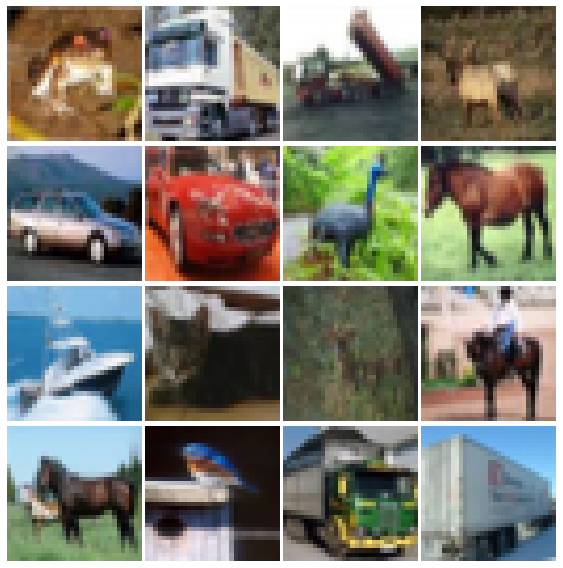

In [153]:
fig, ax_array = plt.subplots(4, 4, figsize=[8, 8])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

Here are the first 8 boat pictures

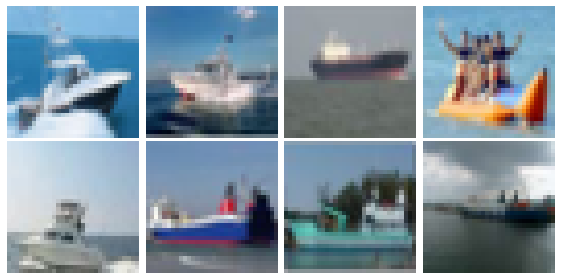

In [154]:
fig, ax_array = plt.subplots(2, 4, figsize=[8, 4])
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_train[y_train == 8][i], cmap='Greys')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [92]:
x_train.shape

(50000, 32, 32, 3)

In [109]:
pca = PCA(n_components=25).fit(x_train.reshape(-1, 32*32*3))

In [110]:
x_train_pca = pca.transform(x_train.reshape(-1,32*32*3))

One thing I notice is that PCA does not separate the images nearly as much as it does to the MNIST digits. 

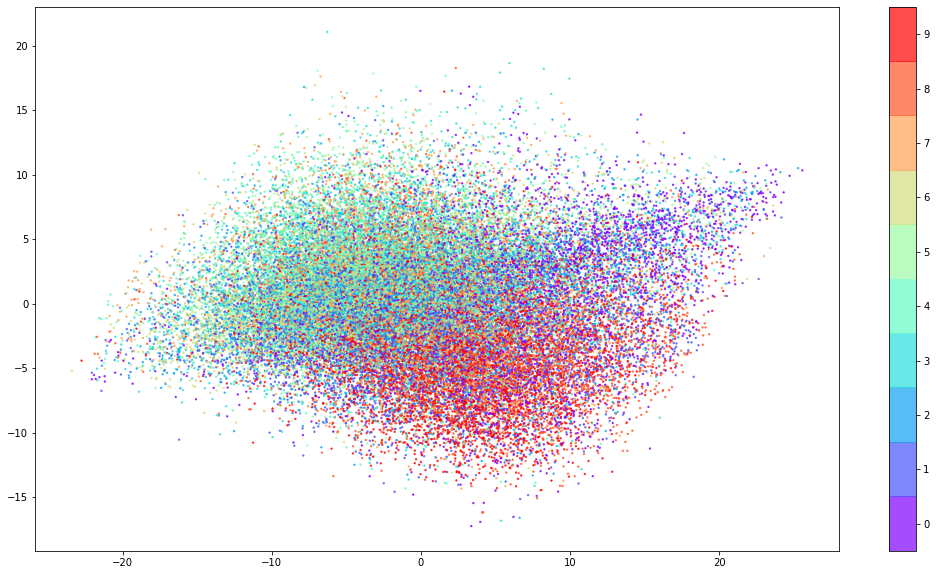

In [111]:
plt.figure(figsize=[18,10])
plt.scatter(x_train_pca[:,0], x_train_pca[:,1], c = y_train.reshape(50000,), cmap='rainbow', s=2, alpha = .7)
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

In [118]:
pca.components_[0].reshape(32,32,3).shape

(32, 32, 3)

## Now lets compare PCA+SVM vs. LR

In [120]:
t0 = time()
lr = LogisticRegression()
lr.fit(x_train.reshape(-1, 32*32*3), y_train)
print("Logistic Regression training done in %0.3fs" % (time() - t0))

Logistic Regression training done in 23.755s


In [122]:
t0 = time()
print("Logistic Regression Accuracy: %0.3f percent" %lr.score(x_test.reshape(-1, 32*32*3), y_test))
print("Logistic Regression testing done in %0.3fs" % (time() - t0))

Logistic Regression Accuracy: 0.406 percent
Logistic Regression testing done in 0.235s


In this case, an SVM with PCA still only gets about 50% correct. 

In [124]:
t0 = time()
pca_clf = SVC(gamma='scale', C=1, class_weight='balanced')
pca_clf.fit(x_train_pca, y_train)
print("SVM training done in %0.3fs" % (time() - t0))

SVM training done in 206.183s


In [126]:
t0 = time()
x_test_pca = pca.transform(x_test.reshape(-1, 32*32*3))
print(pca_clf.score(x_test_pca, y_test))
print("SVM testing done in %0.3fs" % (time() - t0))

0.5074
SVM testing done in 23.834s


## CNN works better
After training for 10 epochs, the CNN is ~67% accurate and has passed the SVM and LR.

In [155]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [156]:
img_train, img_val, labels_train, labels_val = train_test_split(x_train, y_train, test_size = 0.2)

In [172]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 64)       

In [173]:
train_model = model.fit(img_train, labels_train,
                       batch_size = 32,
                       epochs = 10,
                       verbose = 1,
                       validation_data = (img_val, labels_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 84s 2ms/step - loss: 1.8651 - accuracy: 0.3146 - val_loss: 1.5793 - val_accuracy: 0.4279
Epoch 2/10
40000/40000 [==============================] - 87s 2ms/step - loss: 1.5405 - accuracy: 0.4402 - val_loss: 1.3697 - val_accuracy: 0.5127
Epoch 3/10
40000/40000 [==============================] - 87s 2ms/step - loss: 1.4096 - accuracy: 0.4920 - val_loss: 1.2592 - val_accuracy: 0.5510
Epoch 4/10
40000/40000 [==============================] - 88s 2ms/step - loss: 1.3234 - accuracy: 0.5268 - val_loss: 1.2354 - val_accuracy: 0.5610
Epoch 5/10
40000/40000 [==============================] - 86s 2ms/step - loss: 1.2546 - accuracy: 0.5538 - val_loss: 1.1721 - val_accuracy: 0.5867
Epoch 6/10
40000/40000 [==============================] - 88s 2ms/step - loss: 1.1936 - accuracy: 0.5759 - val_loss: 1.0651 - val_accuracy: 0.6250
Epoch 7/10
40000/40000 [==============================] - 87s 2ms/st

In [174]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 8s 793us/step
Test loss: 0.9450083375930786
Test accuracy: 0.6676999926567078
